# Leech trees

Much of this code is whole cloth and should be re-factored as networkx code.

In [1]:
from numpy import zeros
from operator import itemgetter
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import random as r
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# Define the parameters of the tree
n = 16
nc2 = n*(n-1)/2
sumLT = (nc2 + 1)*(nc2)/2

vList = range(n)
eList = range(n-1)

# v[] is a list of vertices
v = []

# e[] is a list of edges
e = []
best_e = []


# h[] is a histogram of path counts, ordinate = path sum
h = []
best_h = []

# The path p will be a list of vertex indices (integers)
# The compiled pathlist paths[] is a list of lists: each a p[] list
# pp[] tracks the path length: Exhaustion of vertices index
p = []
pp = []
paths = []

# kilroy buggy...
beenThere = []

wgt = zeros((n,n),int)

# weighted is a mask of edge indices that have had weights assigned
weightedMask = zeros(n-1, int)

# weights is a mask of possible weight values that have been assigned to edges
weightsMask = zeros(n*n, int)

# racks up goodness scores upon each gauntlet run
howgoods = []

# lr[] is how many vertices are to the left (versus right) of edge i
#   This is because all edges in the tree separate the tree into two parts
#     in only one way; this is unambiguous.
#   l_i + r_i = n where left is arbitrarily the lesser of the two
#   The lr[] list has n-1 elements, one for each edge
lr = []

In [3]:
def LoadWeightsUnderscoreWithReassignment(verbose):
    SetUnderscoreWeightsRandomly()
    FillWgt()
    passes = 0
    while True:
        passes += 1
        iX = SmallestWeightInHistogramMoreThanOnce()
        if iX < 0:
            if verbose: print ('scram with iX', iX, 'pass', passes)
            break
        degenerateEdge = FirstEdgeIndexWithWeight(iX)
        if degenerateEdge < 0:
            if verbose: print ('exiting at degenEdge', degenerateEdge, 'at iX', iX)
            break
        (lgstW, lgstI) = LargestWeightAndIndex()
        if lgstI < 0:
            if verbose: print ('sortie with lgstI', lgstI, 'lgstW', lgstW)
            break
        e[degenerateEdge].weight = lgstW + 1
        FillWgt()
        FillH(False)
        HowGood(False)
        (coincWeight, coincIndex) = HistogramTwoCoincidesWithSomeWeight()
        if coincWeight == 0:
            if verbose: print ('bailing at weight', lgstW + 1, 'with h[:30]', h[:30])
            break
        else:
            if verbose: print ('h[w] = 2 coincidence at edge', coincIndex, 'with weight', coincWeight)
    if verbose: print (wgt)
    return

In [4]:
# Ok so I wrote a little 'class' code to start getting the hang of it, a 'first draft'

# The vertex class describes a given vertex in the tree
class vertex(object):
    """a tree vertex with adjacent vertices and incident edges built in"""

    def __init__(self, index, value, vertices, edges):
        self.index = index                   # tuple (file, rank)
        self.value = value                   # a weight
        self.vertices = vertices             # connected vertices list: where a path could go from here
        self.edges = edges                   # incident edges list
 
    # The informal string definition; contrast __repl__()
    def __str__(self):
        return "index {}:\nStatus: {}, {}, {} vertices, {} edges\n".format(self.index, self.value, len(self.vertices), len(self.edges))

# The edge class describes a given edge in the tree
class edge(object):
    """a tree edge incident to two vertices"""

    def __init__(self, index, weight, v1, v2):
        self.index = index                   # tuple (file, rank)
        self.weight = weight                   # a weight
        self.v1 = v1                         # first vertex this edge is incident to
        self.v2 = v2                         # second vertex this edge is incident to
 
    # The informal string definition; contrast __repl__()
    def __str__(self):
        return "index {}:\nStatus: {}, {} v1 {} v2 {}\n".format(self.index, self.weight, self.v1, self.v2)

In [5]:
# Create a tree of n vertices and n-1 edges
def CreateTree():

## Starfish
##    v.append(vertex(0,0,[1,2,15],[0,1,2]))
##    v.append(vertex(1,0,[0],[0]))
##    v.append(vertex(2,0,[0],[1]))
##    v.append(vertex(3,0,[4,5,15],[3,4,5]))
##    v.append(vertex(4,0,[3],[3]))
##    v.append(vertex(5,0,[3],[4]))
##    v.append(vertex(6,0,[7,8,15],[6,7,8]))
##    v.append(vertex(7,0,[6],[6]))
##    v.append(vertex(8,0,[6],[7]))
##    v.append(vertex(9,0,[10,11,15],[9,10,11]))
##    v.append(vertex(10,0,[9],[9]))
##    v.append(vertex(11,0,[9],[10]))
##    v.append(vertex(12,0,[13,14,15],[12,13,14]))
##    v.append(vertex(13,0,[12],[12]))
##    v.append(vertex(14,0,[12],[13]))
##    v.append(vertex(15,0,[0,3,6,9,12],[2,5,8,11,14]))

## Horsetail 1 - 1 - 1 - 1 - 1
##           |   |   |   |   | (or Wiwaxia!? Hallucigenia?!)
##           2   2   3   2   2
##    v.append(vertex(0,0,[1,2,3],[0,1,2]))
##    v.append(vertex(1,0,[0],[0]))
##    v.append(vertex(2,0,[0],[1]))
##    v.append(vertex(3,0,[0,4,5,6],[2,3,4,5]))
##    v.append(vertex(4,0,[3],[3]))
##    v.append(vertex(5,0,[3],[4]))
##    v.append(vertex(6,0,[3,7,8,9,10],[5,6,7,8,9]))
##    v.append(vertex(7,0,[6],[6]))
##    v.append(vertex(8,0,[6],[7]))
##    v.append(vertex(9,0,[6],[8]))
##    v.append(vertex(10,0,[6,11,12,13],[9,10,11,12]))
##    v.append(vertex(11,0,[10],[10]))
##    v.append(vertex(12,0,[10],[11]))
##    v.append(vertex(13,0,[10,14,15],[12,13,14]))
##    v.append(vertex(14,0,[13],[13]))
##    v.append(vertex(15,0,[13],[14]))

    # linear / chain (works fine for even or odd n)
    # But: Please see http://people.math.sc.edu/laszlo/leech7.pdf which is Laszlo Szekely and 2 others
    #   'some negative results' papers. This shows that a chain is impossible; which is rather discouraging
    #   since chains generate the best empirical scores. The rationale is instructive: The entire chain must
    #   be the last sum and must therefore have all the integer edge weights 1, 2, 3, ..., n-1; where 1 must
    #   be at the end and must be adjacent to the (n-1) weight. 
    v.append(vertex(0,0,[1],[0]))
    for i in range(1,n-1):
        v.append(vertex(i, 0,[i-1,i+1],[i-1,i]))
    v.append(vertex(n-1,0,[n-2],[n-2]))

##    # star (works fine for even or odd n)
##    v.append(vertex(0,0,[],[]))
##    for i in range(1, n): # takes values 1, 2, ..., n-1
##        v[0].vertices.append(i) # adds the radial vertices 1, 2, ..., n-1
##        v[0].edges.append(i-1) # takes values 0, 1, ..., n-2, total of n-1
##        v.append(vertex(i,0,[0],[i-1])) # takes edge values as prev line
##
##    # generalized barbell (works fine for even or odd n)
##    # vertices 0 and 1 are the hubs of two stars
##    # (n-2)/2 vertices allocated to each hub but we can make this more general as (a) and (n-2-a)
##    a = (n-2)/2
##    b = n - (2 + a)    # this works properly for odd values of n as well
##    v.append(0, 0, [1], [0])   # the two hubs are connected via edge 0
##    v.append(1, 0, [0], [0])
##    for i in range(a):
##        v[0].vertices.append(i+2)  # first hub connects to vertex i+2
##        v[0].edges.append(i+1)     #   via edge i+1
##        v.append(i+2,0,[0],[i+1])  #   and that vertex connects back
##    for i in range(b):
##        v[1].vertices.append(i+2+a)   # so if a = 1 we begin at vertex 3
##        v[1].edges.append(i+1+a)      #   and edge 2
##        v.append(i+2+a,0,[1],[i+1+a]) #   and that vertex connects back to vertex 1 via same 
                   
    # build the edge list from the vertex list; easier to get at weights this way
    for i in eList:
        e.append(edge(i,-1,0,0))
    for i in vList:
        vv = v[i]
        ne = len(vv.vertices)
        for j in range(ne):
            ee = e[vv.edges[j]]
            if ee.weight == -1:
                ee.weight = 0
                ee.v1 = i
                ee.v2 = vv.vertices[j]

In [6]:
def Is_p_in_paths(p):
    global paths
    p_reversed = p[:]
    p_reversed.reverse()
    if p in paths or p_reversed in paths: return True
    return False

def Step(i):
    global p
    global paths
    global pp
    global ppI
    global v
    
    # push vertex i onto the path
    p.append(i)

    # a new path p adds to paths iff not there yet *and* more than one vertex in length
    if len(p) > 1 and not Is_p_in_paths(p): paths.append(p[:])
    
    # path pointer is a List index that points to the zeroth neighbor of this vertex
    pp.append(0)
    ppI = len(pp)-1
    # Now pp[ppI] is the *index* of "next vertex to consider"
    #   access this via v[i].vertices[pp[ppI]]

    while True:
        # out of 'next vertex to consider's? fall out of while
        #   graph is connected so len(v[i].vertices) is 1 or more
        if len(v[i].vertices)-1 < pp[ppI]: break

        # nvtc stands for 'next vertex to consider'
        #   we have established that it is ok to index into it
        nvtc = v[i].vertices[pp[ppI]]
        if not nvtc in p: Step(nvtc)

        # increment the path pointer 
        pp[ppI] += 1

    # fell through to here: nowhere to go
    #   unpoint to this distal vertex
    ppI -= 1
    #   pop this distal vertex off the path
    p.pop()
    #   pop this distal index off the pointer list
    pp.pop()    
    return

In [7]:
# I think we have to bookkeep two things: 'beenThere' as a countable list of
#   'do not count this one again' and the path { p[], pp[], ppI } to track where we
#   are and which avenues have been explored. 'nope' is a do not go this way vertex
#   (being the other end of the edge in question). I suspect beenThere[] is sufficient
#   so this earns a kilroy: Can beenThere do p[]'s job? 
def AccumulateVerticesInSubTree(v0, nope):
    global p
    global pp
    global ppI
    global v
    global beenThere
    if not v0 in beenThere: beenThere.append(v0)
    p.append(v0)
    pp.append(0)
    ppI = len(pp)-1
    while True:
        if len(v[v0].vertices)-1 < pp[ppI]: break
        nvtc = v[v0].vertices[pp[ppI]]
        if nvtc != nope and not nvtc in p: AccumulateVerticesInSubTree(nvtc, nope)
        pp[ppI] += 1
    ppI -= 1
    p.pop()
    pp.pop()
    return

def GeneratePaths():
    for i in vList:
        Step(i)

def GenerateLeftRight():
    global lr
    global p
    global pp
    global beenThere
    for i in eList:
        v1 = e[i].v1
        v2 = e[i].v2
        p = []         # kilroy bad practice: not passed; global
        pp = []        # kilroy ditto
        beenThere = [] # kilroy ditto
                       # kilroy this just raises the general topic of how to deal with data structures in recursive functions
        AccumulateVerticesInSubTree(v1, v2)
        left = len(beenThere)
        if (left > n/2): left = n - left
        lr.append(left)
    # print 'lr',lr
    # Calculate the sum of all paths based on the left-right calculation
    lrSum = 0
    for i in range(1,int(n/2+1)):
        thisSum = 0
        for j in eList:
            if lr[j] == i: thisSum += e[j].weight
        # i*(n-i) is how many times this edge is traversed amongst all the paths
        thisSum *= i*(n - i)
        lrSum += thisSum
    # print 'lrSum', lrSum

In [8]:
# Simple procedure for assigning random weights but the first two are 1 and 2 since they are necessary to an LT
def LoadWeights(verbose):
    unity = r.randint(0, n-2)
    e[unity].weight = 1
    weightedMask[unity] = 1
    weightsMask[1] = 1
    deuce = unity
    while deuce == unity:
        deuce = r.randint(0, n-2)
    e[deuce].weight = 2
    weightedMask[deuce] = 1
    weightsMask[2] = 1
    for i in range(2, n-1):
        while True:
            nextWeight = r.randint(3,37)
            nextEdge = r.randint(0, n-2)
            if weightsMask[nextWeight] == 0 and weightedMask[nextEdge] == 0: break
        weightsMask[nextWeight] = 1
        weightedMask[nextEdge] = 1
        e[nextEdge].weight = nextWeight
    FillWgt()
    if verbose: print (wgt)
    return

In [9]:
def HowGood(verbose):
    global h
    sum0 = 0
    sum1 = 0
    sum2 = 0
    sumX = 0
    for i in range(int(nc2)):
        if h[i] == 0: sum0 += 1
        elif h[i] == 1: sum1 += 1
        elif h[i] == 2: sum2 += 1
        else: sumX += 1
    howGood = float(sum1)/float(nc2)
    if verbose: print ('sums:', sum0, sum1, sum2, sumX, 'how good = ', howGood)
    return howGood
        

In [10]:
def FillH(verbose):
    global paths
    global h
    nPaths = len(paths)
    h = [0]*(len(paths)+1)
    grandSum = 0
    for path in paths:
        thisSum = 0
        for i in range(len(path)-1):
            thisSum += wgt[path[i]][path[i+1]]
        grandSum += thisSum
        # h[] is the histogram and it may have entries that exceed (n choose 2) so we have to clip those
        # h[0] is how many paths have weight 0 (which in a typical scheme will be Zero)
        # h[1] is how many paths have weight 1 and so on
        # h[] indexing runs all the way to nc2 inclusive, therefore:
        if thisSum > nc2: thisSum = nc2
        h[int(thisSum)] += 1
    # print 'grandSum', grandSum
    # print 'LT sum', sumLT

# Leech trees interpreted


Noted 9/17/2023


Suppose $G$ is a tree graph with $n$ vertices and a positive integral weight assigned each of the $n-1$ edges. 
A path sum is the sum of
weights while traversing the unique path between two vertices of $G$. A Leech tree is such a graph where
all paths generate a set of path sums $\{ 1, 2, 3, \dots, n-choose-2 \}$. 
Leech trees are easy to construct for a small number of vertices but only five are known. A theorem by
Taylor shows that $n$ must either be a square or a square plus 2. 


In the code below certain candidate trees $G$ are generated and evaluated for their proximity to the Leech 
criterion. In this process some nomenclature is defined. 


> Not clear at the moment: How is the structure of the tree decided? One extreme: Linear. Other extreme: 
Dandelion. 


- h[] is a histogram list
    - h[0] will be zero as each of the $n-1$ edges has a unique weight in $Z^+$
- $_1$ means there is one path with sum 1. $_2$ means one path with sum 2, etcetera; $_7$ means one path with sum 7
- $+1$ means there is more than one path with sum 1: Exceeding the Leech criterion
- $-1$ means there are zero paths with sum 1: Below the Leech criterion


An "underscore run" means the histogram consists of (as desired) scores $1 1 1 1 \dots 1$ up to some histogram element $a$.
When $a < n_choose_2$ we do not yet have a Leech tree: So it is a *Low* Underscore Run or LUR. 
Another graph with underscore run $_1...b$ with $b>a$ represents an improvement towards a Leech tree.


The 'toothpaste' strategy is an attempt to go from $a$ to $b$ in this manner: Count upwards from
$3$ on the histogram list $h[]$. 3 is the first number that can be present in two different ways 
on the list of path sums: $1 + 2$ or $3$. When a histogram entry $h[a]$ is found with value $2$ 
we have a path degeneracy: The edge with value $a$ is degenerate with two or more other edges
that sum to $a$. Since in this ascent the edge $a$ has been previously involved in the histogram
values (it is too large): It can be increased in value. This is the 'squeezing out the toothpaste'
idea: By changing $a$ to some larger number the value of $h[a]$ drops from 2 to 1. 


To implement the toothpaste strategy it is necessary to have a list of all the assigned edge weights
up to this point. In this way the $a$ weight can be assigned a new weight, which is the smallest
available such weight not found on that list. As there are initially $n-1$ assigned weights and
$\frac{n^2-n}{2}$ path sums in a Leech tree, there are many available weight reassignments possible.


Notice that h[a]=3 is triply degenerate and this is not repaired by the toothpaste strategy above.


[This URL](https://people.math.sc.edu/laszlo/leech7.pdf)
is a paper showing that $n \ge 16$; no point in checking $n=9$ or $n=11$. 
There are also extensions of the Leech tree idea to be easily found online.



It seems that the chosen geometry is a simple chain.


Interpretation: 'Best score' is the ratio of histogram elements with value $1$ to $n-choose-2$. 










In [11]:
# Load Weights toothpaste scheme
# 
# Note of interpretation 9/17/2023: Look above at the markdown cell
#
# h[] is indexed by path sum, indicates how many paths have that sum, 0, 1, 2, ... nc2.
#   Higher sums are clipped > nc2 bin. h[0] is 0 unless testing with 0-weight edges.
#   Underscore n written _n means h[n] = 1. +n: h[n] > 1, -n: h[n] == 0. _1...n means
#   h[i] = 1, 'underscore run' UR. A Leech Tree LT is defined as _1...nc2. Moving h[] towards LT
#   is 'improving the underscore'. _1...a is a Low Underscore Run LUR.
#
# Kilroy Criterion (kc): Each edge divides the tree into two sub-trees with (a) and (n-a) vertices
#   so this edge will be traversed a * (n - a) times contributing that edge weight w that many times
#   to the total weight. (a) will range from 1 to floor(n/2). This summed over all edges must in an LT
#   be equal to (nc2+1) choose 2. 
#
# The toothpaste Monte Carlo scheme:
#   - Assign weights 1, 2, ..., n-1 randomly to the (n-1) edges in the tree
#   - Repeat until nothing to do:
#     - Walk up h[] looking for smallest i for which h[i] = 2.
#     - Presume there is a single edge of weight i giving a degenerate sum with some longer path
#       - Change this weight to the next largest available weight
#
# LEFT OFF HERE BECAUSE I HAD AN IDEA: MAKE SURE THE RELOCATION VERTEX HAS h[]=0
#
#
# for edge weights: Assign 1, 2, ..., n-1 randomly to begin with a 'for sure'
#   LUR up to (n - 1). The look for h[i] = 2 (counting upwards from 3) so to identify degenerate
#   edges. Assign these new weights > the largest weight so far. This preserves/extends the LUR
#   and expands the span of h[]. If h[] > 2 then this fix does not get us to h[] = 1. With 2 or more
#   degenerate multi-edge paths a reassignment scheme is not clear. Those paths are likely
#   to share edges on small trees; so 2 + n + 4 = 1 + n + 5 and changing n may remove the
#   sum from the LUR. Changing 1, 2, 4 or 5 will break some other part of the LUR. Perhaps
#   the best strategy is to just give up on this distribution. 
#
# Toothpaste actually works well in the MC sense: A handful of attempts per one million on n = 16 with
#   a fixed tree structure (central + 5 identical Y-shaped sub-trees) exceed a score of 0.60 where
#   largest found so far is 0.625, interesting as this is 10/16. Whereas typical tries produce a flat
#   LUR followed by central peaks and zeros followed by a stretch of zeros: These rare cases tend to
#   extend all the way up to nc2.
#
# One strategy is to build on the toothpaste approach by engineering how larger edge weights are
#   modified given some decent LUR. This strategy might for example include satisfying KC. 
#
# One idea that seems un-helpful is to build from LUR-supporting sub-trees. The idea would be
#   that they would add to larger weights to tile continuous segments of the LT. It also occurs
#   to me that the failure of this idea might be used to prove no larger LTs. But overall this
#   feels just meh-inconclusive at the moment.
#
# Legacy thought: Define LT6 as the 6-vertex LT with weights 1, 2, 4, 5, 8. (1 and 2 are at one side, 4 and 8
#   on the other, 5 is the bridge.) Is LT6 a good core since it gives LUR _1..15? I think it would be
#   worth proving that no such sub-tree can be part of a larger LT. First it would help to verify that 9 and 11
#   are established as impossible, hence LT16, LT18, ... are the next candidates and 120 is the least
#   distance we must go. Suppose LT6 is part of this larger LT. Then LT must attach to LT6 in one or more
#   locations with no loops. Added weights must be 16 or higher. Take s to be the least-weighted edge
#   touching LT6. If this attaches to a vertex of edge weight 1 then we get an UR s, s+1.
#   If at the 1-2 vertex: s, s+1, s+2, (not s+3) (not s+4) s+5, (not s+6), (not s+7), (not s+8),
#   s+9, (not s+10), (not s+11), (not s+12), s+13, (not s+14), (not s+15): 10 of 15 possible
#   extensions are gone. Those would necessarily be covered by other paths in an LT. What I
#   conclude is that LT6 is not a good tool for covering h[] upwards from s. 
#
# Returning to the KC extension idea to toothpaste:
#     - some of the n-1 edges are co-opted into LUR and are not available
#     - the remaining (n-1) - LUR edges must give a weighted sum (based on lr[] the left-right List)
#         equal to the sum of 1 + 2 + ... + nc2. This uses the weight left * (n - left) which is
#         largest when left is n/2. In other words: Edges that reside in the center of the tree are
#         counted the most times, leaves the least.
#     - Therefore without changing the structure of the tree the main thing boils down to a set of
#         alpha coefficients and a set of edges divided into sets with the same left-number:
#         a1 * { w_1 } + a2 * {w_2} + ... + a_(n/2) * { w_(n/2) } = Sum - sum(LUR weights) where
#         Sum = (nc2 + 1) choose 2. Each set in this expression is actually the sum of the weights
#         with that left-value: 1, 2, ..., (n/2). 
#     - This suggests that the LUR sub-tree be connected... otherwise modifying a key edge will
#         break the LUR. In turn suggests writing code to check for this feature.
#     - The above equation is one equation in (n-1) - LUR unknowns with a little bit of constraint
#         but we could imagine further guidance on how the weights are distributed. An exhaustive search
#         might even be feasible at this point: Suppose the LUR uses up 8 of 15 edges; then we have less
#         than 7! arrangements of the remaining weights but of course multiple schemes for choosing them.
#
#   Next: Laplacian formalism e.g. concerning eigenvalues of trees; and then experimentally what
#   do we see for different strategies or MC. That is, it would be trivial except that I forget what
#   the exigencies were for weighted graphs. 
#
#   Next we have not yet gotten into placing weights on vertices and collecting these over paths.
#   These in turn could leak into the edges. Vertex weights at endpoints included? 
#
#   Malleable tree structure
#
#   Distance heuristic from the knight's tour.
#
#   Taylor's even and odd; and what about K-G-style thinking? Other scoring that correlates to the
#   various h[] scores (and multiple possible forms of this).
#
#   Software: Speed and style.
#
#   Hall of fame.
#

In [12]:
def ZeroWeights():
    for i in eList:
        e[i].weight = 0
    return

def SetUnderscoreWeightsRandomly():
    ZeroWeights()
    aPick = 0
    for i in eList:
        while True:
            aPick = r.randint(0, n-2)
            if e[aPick].weight == 0:
                break
        e[aPick].weight = i + 1
    return

def SmallestWeightInHistogramMoreThanOnce():
    FillH(False) # loads h[]
    for iX in range(1, int(nc2 + 1)): # 1, 2, ..., nc2
        if h[iX] > 1: return iX
    return -1

def FirstEdgeIndexWithWeight(w):
    for i in eList:
        if e[i].weight == w: return i
    return -1

def LargestWeightAndIndex():
    wL = -1
    iL = -1
    for i in eList:
        if e[i].weight > wL:
            wL = e[i].weight
            iL = i
    return (wL, iL)

In [13]:
def Strategy():
    return (0,-1)

def FillWgt():
    for i in eList:
        wgt[e[i].v1][e[i].v2]=e[i].weight
        wgt[e[i].v2][e[i].v1]=e[i].weight
    return

def SmallestNonzeroZeroValuedIndexInHistogram():
    for i in range(1, int(nc2+1)):
        if h[i] == 0: return i
    return 0

def HistogramTwoCoincidesWithSomeWeight():
    for i in range(1,int(nc2)+1):
        if h[i] == 2:
            for j in eList:
                if e[j].weight == i: return (i, j)
    return (0, -1)

In [14]:
def PlotH():
    plt.plot(h)
    plt.show()

def PlotHowGoods():
    plt.plot(howgoods)
    plt.show()

def PlotGraph():
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in eList:
        G.add_edge(e[i].v1,e[i].v2,weight=e[i].weight)
    pos=nx.spring_layout(G)
    nx.draw(G,pos)
    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    plt.show()



def PrintSortedEdgeWeights():
    lowestValueSoFar = 0
    nPrinted = 0
    while True:
        bestValue = 1000000
        for i in eList:
            if e[i].weight > lowestValueSoFar and e[i].weight < bestValue:
                bestValue = e[i].weight
                bestIndex = i
        lowestValueSoFar = e[bestIndex].weight
        print (lowestValueSoFar,)
        nPrinted += 1
        if nPrinted == n - 1: break
    return

In [15]:
def PrintKilroyCriterion():
    print ('KC not done yet')

def LoadWeightsURPlusBackfill(verbose):
    LoadWeightsUnderscoreWithReassignment(verbose)
    while True:
        tryAgain = False
        iX = SmallestNonzeroZeroValuedIndexInHistogram()
        if iX > 0:
            (lgstW, lgstI) = LargestWeightAndIndex()
            if lgstW > iX:
                e[lgstI].weight = iX
                FillWgt()
                FillH(False)
                tryAgain = True
                print ('adjusted',lgstW,iX)
        if not tryAgain: break
    return           

In [16]:
scores = []
CreateTree()
GeneratePaths()
GenerateLeftRight()
bestScore = 0.0
sumScore = 0.0
nTrials = 100000
modCheck = 10000
for counter in range(nTrials):
    LoadWeightsUnderscoreWithReassignment(False)
    # LoadWeightsURPlusBackfill(False)
    FillH(False)
    # print wgt
    # PrintSortedEdgeWeights()
    thisScore = HowGood(False)
    sumScore += thisScore
    if thisScore > bestScore:
        bestScore = thisScore
        best_h[:] = h
        best_e[:] = e
        kcSum = 0
        kcSum1 = 0
        for i in eList:
            kcSum += lr[i]*(n - lr[i])*e[i].weight
        print (wgt)
        print ('...gives', bestScore, 'at', counter, 'kc', kcSum, '(', sumLT, '), avg', sumScore/float(counter+1))

    if (counter + 1) % modCheck == 0: print ('.....progress...', counter + 1, '    of ', nTrials)
    scores.append(thisScore)
    #PlotH()

[[ 0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0 19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  5  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 11  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0 15  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0]]
...gives 0.5666666666666667 at 0 kc 6800 ( 7260.0 ), avg 0.5666666666666667
.....progress... 0
[[ 0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0 17  0  0  0  0  0  0  0  0  0

best score =  0.6833333333333333 average =  0.47028266666666413


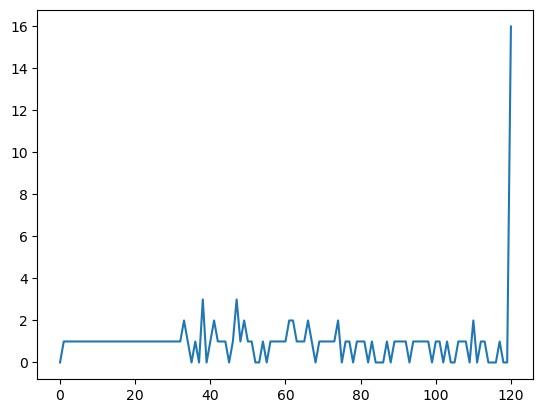

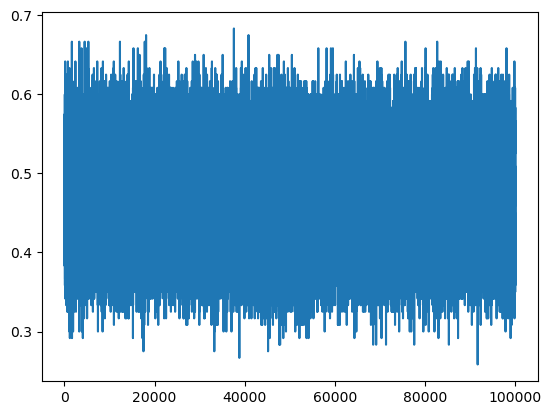

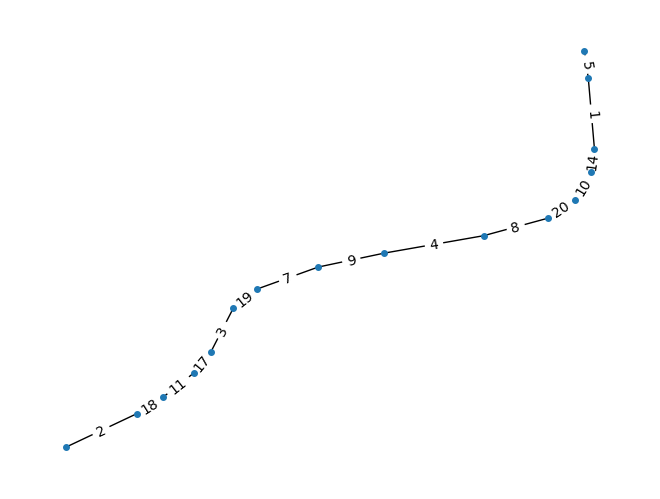

In [17]:
def PlotBestGraph():
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in eList:
        G.add_edge(best_e[i].v1,best_e[i].v2,weight=best_e[i].weight)
    pos=nx.spring_layout(G)
    nx.draw(G,pos,node_size=16)
    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    plt.show()
    
# print scores
print('best score = ', bestScore, 'average = ', sumScore / float(nTrials)) 
plt.plot(best_h)
plt.show()
plt.plot(scores)
plt.show()
PlotBestGraph()
plt.show()

#
# kc for toothpaste tends low, like 6700 < 7260
# toothpaste on starfish n=16: average 0.197
#   Y-appendage weight pairs + 5 radial spokes in same order:
#   .625: 4,8 29,32 10,25 11,39 1,2 9,33,21,40,5
#   .625: 29,30 1,5 17,34 7,26 2,9 33,3,21,32,10
#   .633: 8,30 20,40 25,39 5,10 1,34 37,24,4,9,2
#   .633: 2,5 4,8 29,30 9,26 27,32 1,10,31,33,22
#   .64166: 5,29 2,1 30,40, 32,24, 36,39 9,6,19,31,4 
#   .65833: 39,45 26,44 2,30 7,21 19,29 15,9,3,1,46
# toothpaste on horsetail (5 nodes + 2,2,3,2,2) n = 16: average 0.230
#   Working nodes across: spike, spike + lateral
#   .64166: 3,37+10 5,26+7 2,4,23+36 1,28+34 8,32 (no remaining lateral of course)
#   .65833: 20,29+28 18,16+34 26,30,19+8 17,4+5 2,1; kc 6537;
# star gives 0.1...
# linear avg .468 to .470
#   0.7 kc 8579: 13 27 26 30 3 15 2 4 1 9 28 8 11 12 29
#   0.71666 kc 9253: 2 8 23 30 22 14 1 4 7 6 3 25 24 27 29
#  2 * 1 * 15 + 8 * 2 * 14+ 23 * 3 * 13+ 30 * 4 * 12+ 22 * 5 * 11+ 14 * 6 * 10+  1 * 7 * 9+  4 * 8 * 8+  7 * 7 * 9+  6 * 6 * 10+  3 * 5 * 11+ 25 * 4 * 12+ 24 * 3 * 13+ 27 * 2 * 14+29 * 1 * 15+
# The averages for 18, 25, 27 etcetera continue to drop
#

# First Other Leech Tree notebook notes

## Notice particularly the careful-er reading of the cited non-existence results paper!


```
# Create a tree of n vertices and n-1 edges
def CreateTree():

## Starfish

## Horsetail 1 - 1 - 1 - 1 - 1
##           |   |   |   |   | (or Wiwaxia!? Hallucigenia?!)
##           2   2   3   2   2


    # linear / chain (works fine for even or odd n)
    # But: Please see http://people.math.sc.edu/laszlo/leech7.pdf which is Laszlo Szekely and 2 others
    #   'some negative results' papers. This shows that a chain is impossible; which is rather discouraging
    #   since chains generate the best empirical scores. The rationale is instructive: The entire chain must
    #   be the last sum and must therefore have all the integer edge weights 1, 2, 3, ..., n-1; where 1 must
    #   be at the end and must be adjacent to the (n-1) weight. 





# Load Weights toothpaste scheme
#
# h[] is indexed by path sum, indicates how many paths have that sum, 0, 1, 2, ... nc2.
#   Higher sums are clipped > nc2 bin. h[0] is 0 unless testing with 0-weight edges.
#   Underscore n written _n means h[n] = 1. +n: h[n] > 1, -n: h[n] == 0. _1...n means
#   h[i] = 1, 'underscore run' UR. A Leech Tree LT is defined as _1...nc2. Moving h[] towards LT
#   is 'improving the underscore'. _1...a is a Low Underscore Run LUR.
#
# Kilroy Criterion (kc): Each edge divides the tree into two sub-trees with (a) and (n-a) vertices
#   so this edge will be traversed a * (n - a) times contributing that edge weight w that many times
#   to the total weight. (a) will range from 1 to floor(n/2). This summed over all edges must in an LT
#   be equal to (nc2+1) choose 2. 
#
# The toothpaste Monte Carlo scheme:
#   - Assign weights 1, 2, ..., n-1 randomly to the (n-1) edges in the tree
#   - Repeat until nothing to do:
#     - Walk up h[] looking for smallest i for which h[i] = 2.
#     - Presume there is a single edge of weight i giving a degenerate sum with some longer path
#       - Change this weight to the next largest available weight
#
# LEFT OFF HERE BECAUSE I HAD AN IDEA: MAKE SURE THE RELOCATION VERTEX HAS h[]=0
#
#
# for edge weights: Assign 1, 2, ..., n-1 randomly to begin with a 'for sure'
#   LUR up to (n - 1). The look for h[i] = 2 (counting upwards from 3) so to identify degenerate
#   edges. Assign these new weights > the largest weight so far. This preserves/extends the LUR
#   and expands the span of h[]. If h[] > 2 then this fix does not get us to h[] = 1. With 2 or more
#   degenerate multi-edge paths a reassignment scheme is not clear. Those paths are likely
#   to share edges on small trees; so 2 + n + 4 = 1 + n + 5 and changing n may remove the
#   sum from the LUR. Changing 1, 2, 4 or 5 will break some other part of the LUR. Perhaps
#   the best strategy is to just give up on this distribution. 
#
# Toothpaste actually works well in the MC sense: A handful of attempts per one million on n = 16 with
#   a fixed tree structure (central + 5 identical Y-shaped sub-trees) exceed a score of 0.60 where
#   largest found so far is 0.625, interesting as this is 10/16. Whereas typical tries produce a flat
#   LUR followed by central peaks and zeros followed by a stretch of zeros: These rare cases tend to
#   extend all the way up to nc2.
#
# One strategy is to build on the toothpaste approach by engineering how larger edge weights are
#   modified given some decent LUR. This strategy might for example include satisfying KC. 
#
# One idea that seems un-helpful is to build from LUR-supporting sub-trees. The idea would be
#   that they would add to larger weights to tile continuous segments of the LT. It also occurs
#   to me that the failure of this idea might be used to prove no larger LTs. But overall this
#   feels just meh-inconclusive at the moment.
#
# Legacy thought: Define LT6 as the 6-vertex LT with weights 1, 2, 4, 5, 8. (1 and 2 are at one side, 4 and 8
#   on the other, 5 is the bridge.) Is LT6 a good core since it gives LUR _1..15? I think it would be
#   worth proving that no such sub-tree can be part of a larger LT. First it would help to verify that 9 and 11
#   are established as impossible, hence LT16, LT18, ... are the next candidates and 120 is the least
#   distance we must go. Suppose LT6 is part of this larger LT. Then LT must attach to LT6 in one or more
#   locations with no loops. Added weights must be 16 or higher. Take s to be the least-weighted edge
#   touching LT6. If this attaches to a vertex of edge weight 1 then we get an UR s, s+1.
#   If at the 1-2 vertex: s, s+1, s+2, (not s+3) (not s+4) s+5, (not s+6), (not s+7), (not s+8),
#   s+9, (not s+10), (not s+11), (not s+12), s+13, (not s+14), (not s+15): 10 of 15 possible
#   extensions are gone. Those would necessarily be covered by other paths in an LT. What I
#   conclude is that LT6 is not a good tool for covering h[] upwards from s. 
#
# Returning to the KC extension idea to toothpaste:
#     - some of the n-1 edges are co-opted into LUR and are not available
#     - the remaining (n-1) - LUR edges must give a weighted sum (based on lr[] the left-right List)
#         equal to the sum of 1 + 2 + ... + nc2. This uses the weight left * (n - left) which is
#         largest when left is n/2. In other words: Edges that reside in the center of the tree are
#         counted the most times, leaves the least.
#     - Therefore without changing the structure of the tree the main thing boils down to a set of
#         alpha coefficients and a set of edges divided into sets with the same left-number:
#         a1 * { w_1 } + a2 * {w_2} + ... + a_(n/2) * { w_(n/2) } = Sum - sum(LUR weights) where
#         Sum = (nc2 + 1) choose 2. Each set in this expression is actually the sum of the weights
#         with that left-value: 1, 2, ..., (n/2). 
#     - This suggests that the LUR sub-tree be connected... otherwise modifying a key edge will
#         break the LUR. In turn suggests writing code to check for this feature.
#     - The above equation is one equation in (n-1) - LUR unknowns with a little bit of constraint
#         but we could imagine further guidance on how the weights are distributed. An exhaustive search
#         might even be feasible at this point: Suppose the LUR uses up 8 of 15 edges; then we have less
#         than 7! arrangements of the remaining weights but of course multiple schemes for choosing them.
#
#   Next: Laplacian formalism e.g. concerning eigenvalues of trees; and then experimentally what
#   do we see for different strategies or MC. That is, it would be trivial except that I forget what
#   the exigencies were for weighted graphs. 
#
#   Next we have not yet gotten into placing weights on vertices and collecting these over paths.
#   These in turn could leak into the edges. Vertex weights at endpoints included? 
#
#   Malleable tree structure
#
#   Distance heuristic from the knight's tour.
#
#   Taylor's even and odd; and what about K-G-style thinking? Other scoring that correlates to the
#   various h[] scores (and multiple possible forms of this).
#
#   Software: Speed and style.
#
#   Hall of fame.
#


#
# kc for toothpaste tends low, like 6700 < 7260
# toothpaste on starfish n=16: average 0.197
#   Y-appendage weight pairs + 5 radial spokes in same order:
#   .625: 4,8 29,32 10,25 11,39 1,2 9,33,21,40,5
#   .625: 29,30 1,5 17,34 7,26 2,9 33,3,21,32,10
#   .633: 8,30 20,40 25,39 5,10 1,34 37,24,4,9,2
#   .633: 2,5 4,8 29,30 9,26 27,32 1,10,31,33,22
#   .64166: 5,29 2,1 30,40, 32,24, 36,39 9,6,19,31,4 
#   .65833: 39,45 26,44 2,30 7,21 19,29 15,9,3,1,46
# toothpaste on horsetail (5 nodes + 2,2,3,2,2) n = 16: average 0.230
#   Working nodes across: spike, spike + lateral
#   .64166: 3,37+10 5,26+7 2,4,23+36 1,28+34 8,32 (no remaining lateral of course)
#   .65833: 20,29+28 18,16+34 26,30,19+8 17,4+5 2,1; kc 6537;
# star gives 0.1...
# linear avg .468 to .470
#   0.7 kc 8579: 13 27 26 30 3 15 2 4 1 9 28 8 11 12 29
#   0.71666 kc 9253: 2 8 23 30 22 14 1 4 7 6 3 25 24 27 29
#  2 * 1 * 15 + 8 * 2 * 14+ 23 * 3 * 13+ 30 * 4 * 12+ 22 * 5 * 11+ 14 * 6 * 10+  1 * 7 * 9+  4 * 8 * 8+  7 * 7 * 9+  6 * 6 * 10+  3 * 5 * 11+ 25 * 4 * 12+ 24 * 3 * 13+ 27 * 2 * 14+29 * 1 * 15+
# The averages for 18, 25, 27 etcetera continue to drop
#
```

# Other Leech tree notebook follows


# Leech Trees

This appendix concerns a little corner of graph theory called Leech Trees. Before getting to that however
I needed to copy some instructional code on generating graphs. This code relis on NetworkX being installed
so it is actually three cells: The NetworkX install, a first example and a second example that is complete
    graphs I think.

```
from operator import itemgetter
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout


def Kn(n):
    G = nx.Graph()
    a=range(n)
    G.add_nodes_from(a)
    Kn=[]
    for i in range(n-1):
        for j in range(n-i-1):
            k=j+i+1
            Kn.append((i,k))
    G.add_edges_from(Kn)
    return G

##print G.nodes()
##print G.edges()
##print G.number_of_nodes()
##print G.number_of_edges()

# Complete graph (my code)
# G = Kn(12)
# could also use
# G = nx.complete_graph(12)

# E-R is number of vertices and probability (any two vertices are joined by an edge)
# G = nx.erdos_renyi_graph(500, 0.005)
# G = nx.random_regular_graph(8, 30)

# Going for lattice stuff...
# G = nx.waxman_graph(100, 0.2)
G = nx.grid_2d_graph(3,6,periodic=False)

# This does not work on Azure as of 1/31/17
# might re-try it since I did install graphviz...
# nx.draw_graphviz(G,prog="neato",alpha=.75)

# nx.draw_circular(G, node_color='r',node_size=40,with_labels=False)
# nx.draw_random(G, node_color='r',node_size=50,with_labels=False)
# nx.draw_spectral(G, node_color='g',node_size=50,with_labels=False)
# nx.draw_shell(G, node_color='g',node_size=50,with_labels=False)
# nx.draw_planar(G, node_color='r',node_size=50,with_labels=False)
nx.draw(G)

# fig, ax = plt.subplots(figsize=(12,10))
# ax.plot(px, py)

# plt.axis('equal')
plt.show()

# plt.savefig("graph_name.png")




n = 20

from operator import itemgetter
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import random as r

def Kn(n):
    G = nx.Graph()
    a=range(n)
    G.add_nodes_from(a)
    Kn=[]
    for i in range(n-1):
        for j in range(n-i-1):
            k=j+i+1
            Kn.append((i,k))
    G.add_edges_from(Kn)
    return G
    
def Circular(n):
    G = nx.Graph()
    a = range(n)
    G.add_nodes_from(a)
    C = []
    for i in range(n-1):
        C.append((i,i+1))
    G.add_edges_from(C)
    G.add_edge(n-1,0)
    return(G)

##print G.nodes()
##print G.edges()
##print G.number_of_nodes()
##print G.number_of_edges()

# Complete graph (my code)
# G = Kn(12)
# could also use
# G = nx.complete_graph(12)

# E-R is number of vertices and probability (any two vertices are joined by an edge)
# G = nx.erdos_renyi_graph(40, 0.1)
# G = nx.random_regular_graph(8, 30)
G=Circular(n)
# Going for lattice stuff...
# G = nx.waxman_graph(100, 0.2)
# G = nx.grid_2d_graph(3,6,periodic=False)
# G=nx.hypercube_graph(4)
# nx.draw(G,alpha=.75)
# nx.draw(G, pos=graphviz_layout(G), node_size=1600, cmap=plt.cm.Blues, node_color=range(len(G)))
#,prog='dot')

# print nx.adjacency_matrix(G)
# print nx.laplacian_matrix(G)
# print nx.laplacian_spectrum(G)
# print nx.algebraic_connectivity(G)
# print 'Euler'
# print dir(nx)


# eCirc = nx.hamiltonian_circuit(G)
# print eCirc.next()

nx.draw_circular(G, node_color='r',node_size=40,with_labels=False)
H=G
n_attempts = 0
n_additions = 0
while not nx.is_chordal(H):
    a = r.randint(0,n-1)
    b = r.randint(0,n-1)
    n_attempts += 1
    if a != b and not H.has_edge(b, a):
        H.add_edge(a,b)
        n_additions += 1
nx.draw_circular(H, node_color='k',node_size=20)
print(n_attempts, n_additions)
K=nx.complete_graph(n)
print(nx.is_isomorphic(H,K))
print(n*(n-1)/2)
print(H.number_of_edges())
print(H.number_of_nodes())

    


# nx.draw_random(G, node_color='r',node_size=50,with_labels=False)
# nx.draw_spectral(G, node_color='g',node_size=50,with_labels=False)
# nx.draw_shell(G, node_color='g',node_size=50,with_labels=False)


# fig, ax = plt.subplots(figsize=(12,10))
# ax.plot(px, py)

plt.axis('equal')
plt.show()

# plt.savefig("graph_name.png")

```




# Leech Trees

Concerning a problem in graph theory that probably does not have a solution...

Begin please by running the next cell down which sets up some necessary images.


!curl https://raw.githubusercontent.com/robfatland/othermathclub/master/images/graphs/graphs2_002_Leech_trees.png -o /home/nbuser/graphs2_002_Leech_trees.png -s
from PIL import Image

## Proof section

Everything from here down is about proofs, not problems.


### Leech trees


This is not a problem but rather a proof. You might read it like a story; and it concerns a kind of graph called a tree
so you may wish to brush up on trees first by reading through Book 1 Chapter 12 and Book 2 Chapter 8. 


Each edge of a tree can be assigned a *weight* which, for example a number. You could just as easily make this
number be the length of the edge between the two vertices. Normally we allow graph edges to be 'no particular
length' so this is a new thing we are adding.


Recall that trees are connected and they do not contain any cycles or loops. There is therefore one and only one 
path between any two vertices. On a weighted tree by noting the weights along a particular path we can accumulate 
a sum for that path.


The proof given here concerns a question about weighted trees called Leech trees (after the inventor). We will get
to the proof in a moment but first we should describe what a Leech tree is! Suppose there are $p$
possible paths for a tree with $n$ vertices. The first question is what is $p$? If you like you may work this 
out before continuing.


This question is equivalent to the question "Given a set of $n$ objects how many pairs of objects can be selected?"  The 
answer from combinatorics is *n choose 2* written mathematically as


$$P = \binom{n}{2} = \frac{n\cdot(n-1)}{2!}=\frac{1}{2}(n^2-n)$$


Now: If the tree is arranged in a particular way and the edges are assigned particular weights we can imagine that 
the $P$ path sums might be the numbers 1, 2, 3, 4, 5 and so on up to $P$. Such a tree is called a 
Leech tree. How many such trees are there? Only five have been found to date and this is an unsolved problem 
(as far as I can tell). Now however we know enough to read a proof concerning Leech trees. (This proof is recounted 
[here](http://www.cut-the-knot.org/arithmetic/combinatorics/LeechTrees.shtml) where I have borrowed 
their diagram of the five known Leech trees shown below.)

# Leech trees diagram: Please run this cell with Shift + Enter
!curl https://raw.githubusercontent.com/robfatland/othermathclub/master/images/graphs/graphs2_002_Leech_trees.png -o /home/jovyan/graphs2_002_Leech_trees.png -s
from PIL import Image
Image.open("/home/jovyan/graphs2_002_Leech_trees.png")

#### A Proof Concerning Leech Trees


Herbert Taylor published a proof that any Leech tree must have a number of vertices $n$ which is either a perfect 
square or a perfect square plus two. Notice that the perfect squares are 0, 1, 4, 9, 16 so that the allowed number
of vertices in a Leech tree must be one of 1, 2, 3, 4, 6, 9, 11, 16, 18, 25, 27, ... and 
so on. The proof does not establish whether such Leech trees exist; only that if they do exist then 
their number of vertices will be one of these numbers. To put it another way: It is impossible to construct
a Leech tree with 17 vertices because 17 is neither a perfect square nor a perfect square plus two.


Before going any further let's sketch out the proof so that you can try it on your own. You may begin working
on it directly without reading further of course! Or you can consider this outline as a starter kit; or you 
can simply read through the proof (which is what I did). 


- All edge weights are integers, are therefore even or odd
- About half of the $P$ paths have odd path sums
- Individual vertices can be divided into two sets A and B where...
- ...paths between an A and a B have odd path sums
- The total number of paths with odd path sums can be written in two different ways and set equal
- The remaining arithmetic shows the total number of vertices $n$ to be either...
- ...a perfect square or...
- ...a perfect square plus two...


#### A Computational Analysis of Leech Trees

Leech trees with more than six vertices may or may not exist. One question we can ask at this point is 'Can
we teach a computer to search for Leech trees?' The answer certainly 'yes' but we might be looking for a needle
in an impossibly large haystack. It would be a good idea (before writing the program) to estimate just how 
big that haystack is.


Notice that the five known Leech trees have 2, 3, 4, 4, and 6 vertices. These are all allowed numbers of vertices
so it is a relief that this is consistent with Herbert Taylor's result! Let's consider a Leech tree with 16 vertices 
since L.Szekely determined (using a computer) that there are no Leech trees with 9 or 11 vertices. How long would
it take to search all possible trees with 16 vertices? Well such a tree will have 15 edges but we can begin by
constructing a "necessary tree" of three vertices o--------o--------o. (We don't know the weights yet but
more on this in a little bit.) 


Now we have two edges so we must place 13 additional edges.
Once these edges are placed we will have path sums 1, 2, 3, 4, ..., 120 since 16 choose 2 is 120. 
One of the edge weights will have to be 1
and another will have to be 2 and a third will have to be 4. We don't have to have an edge with weight 3 because
this can be done by placing the 1 and 2 edges next to one another. But the weights must be unique so the only
way to get a path sum of 4 is to have a single edge with weight 4. We can continue to think about rules for
the weights but let's pause on that for a moment just to arrive at a first estimate of the problem size. 

After 1, 2 and 4 there remain 12 more edge weights remaining to determine.
If we use 3 and then manage use the 10 consecutive integers larger than 4: 5, 6, 7, ..., 14 then we notice that
the very last path with path sum 120 would imply 106 as a maximum edge weight. If it were any greater it would 
connect along some path to the 14-weight edge and give a path sum greater than 120, not permitted. So the
edge weights are in the range $[1, 104]$. 


Since we begin with 1, 2 and 4 and must choose 12 additional weights from the set { 3, 5, 6, 7, 8, ..., 106} 
we have $\binom{106}{12}$ which is about $2 \times 10^{15}$. Then we must distribute these
numbers across one of the myriad possible 16-vertex trees... of which there are very many configurations. 
So this problem is computationally huge. It would be nice to have some additional constraints on the numbers
we will use and the tree configuration in order to reduce the computation time to something less than 
the age of the universe. 


